# **Seq2Seq (GRU)**

Complex version is trained on dataset that follows an entire conversation between two characters where each new line is the input and the following line is the output (label). The persona of the label's speaker is stored with the input. When a new character is introduced into the scene, a new conversation is declared.

## **Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/1011: Term Project/Collab Notebooks

/content/drive/.shortcut-targets-by-id/1ZU9nsIwPF3oR15kSIr3Os3Q6e-CKHxOT/1011: Term Project/Collab Notebooks


In [3]:
# Import required packages
import os
import json
import numpy as np
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence #added
from torch.utils.data import Dataset, DataLoader #added
import torch.optim as optim #added
from torch.nn import Embedding #added
from torch.nn import Linear #added

from tqdm import tqdm #added
import tensorflow as tf #added
import matplotlib.pyplot as plt #added
import pandas as pd #added
import re #added

import warnings
warnings.filterwarnings("ignore")

In [4]:
pip install transformers

     |████████████████████████████████| 1.3MB 15.3MB/s 
     |████████████████████████████████| 890kB 48.5MB/s 
     |████████████████████████████████| 2.9MB 64.6MB/s 
     |████████████████████████████████| 1.1MB 41.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=4e747a6e921c2eed9e34be984f71313a0b48b9902ea6a388988222b955838aa8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
!cd "/content/drive/MyDrive/1011: Term Project/Collab Notebooks/Dialogue/"
import sys
sys.path.append('/content/drive/MyDrive/1011: Term Project/Collab Notebooks/Dialogue/')
from sienfield_utils import clean_df

## **Load Seinfeld Data**

In [6]:
#import Seinfeld scripts
df=pd.read_csv('/content/drive/My Drive/1011: Term Project/Collab Notebooks/data/scripts.csv')

In [7]:
#import train personas of main characters
train_personas = {"JERRY": ["your persona: i am a comedian. \nyour persona: i am a compulsive neat freak. \nyour persona: i like to read comic books. \nyour persona: i break up with girls for superficial reasons."],
           "GEORGE": ["your persona: i am very neurotic and always afraid that nobody likes me. \nyour persona: i am selfish and greedy. \nyour persona: i have low self-esteem. \nyour persona: i am cheap."],
            "ELAINE": ["your persona: i am Jerry's ex-girlfriend. \nyour persona: i am the best-educated of my group of friends. \nyour persona: i am cynical and acid-tongued. \nyour persona: i work for a publishing company."],
            "KRAMER": ["your persona: i am Jerry's wacky neighbor. \nyour persona: i don't have a job. \nyour persona: i am caring and friendly. \nyour persona: i am extremely honest and lack tact."]
          }
#import test personas of main characters
test_personas = {"JERRY": ["your persona: i make a living telling jokes. \nyour persona: i like to watch sports. \nyour persona: i am a fan of cartoons. \nyour persona: women find me quirky and charming."],
                  "GEORGE": ["your persona: i am vulnerable and slightly neurotic. \nyour persona: i am short, stocky, and slow-witted. \nyour persona: i am dishonest. \nyour persona: i have eccentric behavior."],
                  "ELAINE": ["your persona: i am intelligent. \nyour persona: i am funny. \nyour persona: i am assertive and confident. \nyour persona: i am edgy and superficial."],
                  "KRAMER": ["your persona: i have eccentric behavior. \nyour persona: i am unemployed. \nyour persona: i always tell the truth. \nyour persona: i have interesting ideas."]
                  }

# **Clean Seinfeld Data**

In [8]:
#clean data with util function
df = clean_df(df)

In [10]:
len(df)

54606

In [9]:
df.head()

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,do you know what this is all about ? do you kn...,1.0,S01E01,1.0
1,1,JERRY,"see , to me , that button is in the worst poss...",1.0,S01E01,1.0
2,2,GEORGE,are you through ?,1.0,S01E01,1.0
3,3,JERRY,"you do of course try on , when you buy ?",1.0,S01E01,1.0
4,4,GEORGE,"yes , it was purple , i liked it , i dont actu...",1.0,S01E01,1.0


In [11]:
id = list(df['Dialogue'].index)

In [12]:
#check for open brackets
for i in id:
  if '(' in df['Dialogue'][i] and ')' not in  df['Dialogue'][i]:
    print(i, df['Dialogue'][i])

3067 hey , you see that sign right there ? ( points to a sign saying " not responsible for valuables "
6993 ( to himself uh oh . my organs are playing chess again .
7111 ( waving eva .
7128 ( patting his head i ' m a comedian .
28553 ( tilts her head down , looking over her glasses in amazement of
30966 " kom pau ( sp ? "
31163 " yes it is . well lets see what i have today . darn it it ' s ham & cheese again and she forgot the fancy mustard . i told her i like that fancy mustard . you could put that fancy mustard on a shoe and it would taste pretty good to me . oh ! she made it up with a cupcake though . hey look at this . you know i got a new system for eating these things . i used to peel off the chocolate now i turn them upside down , i eat the cake first and save the frosting for the end . ( george stops listening and it ' s almost like its own dessert ;
31206 yeah . ( reaches for the purse and finds a piece of paper . he looks annoyed .
39830 now , what are you thinkin ' ? you thi

In [13]:
#check for open square brackets
for i in id:
  if '[' in df['Dialogue'][i] and ']' not in  df['Dialogue'][i]:
    print(i, df['Dialogue'][i])

28739 well , one cannot help [ but wonder what brings you into a crummy little coffee shop like this .
45963 jerry , i ' m trapped under my desk . steinbrenner is in the room . you got to help [ me .


In [14]:
#manual adjustments
df['Dialogue'][3067] = 'hey , you see that sign right there ? '
df['Dialogue'][6993] = 'uh oh. my organs are playing chess again.'
df['Dialogue'][7128] = "i'm a comedian."
df['Dialogue'][30966]  = 'kom pau'
df['Dialogue'][31163] = "yes it is . well lets see what I have today . darn it it ' s ham & cheese again and she forgot the fancy mustard . i told her i like that fancy mustard . you could put that fancy mustard on a shoe and it would taste pretty good to me . oh ! she made it up with a cupcake though . hey look at this . you know i got a new system for eating these things . i used to peel off the chocolate now i turn them upside down , i eat the cake first and save the frosting for the end ."
df['Dialogue'][31206] = 'yeah .'
df['Dialogue'][39830] = "now , what are you thinkin ' ? you think that i ' m not able to wear jeans anymore ? is that what you ' re sayin ' ? because if that ' s what you ' re sayin ' , jerry , i ' ll go and i ' ll buy some jeans . i swear to god i will ! "
df['Dialogue'][43280] = "oh , right ! right ! hey , hey ; i love the floors in here . it ' s like a gymnasium in here ! try and guard me !"
df['Dialogue'][49780] = "spite never sleeps "
df['Dialogue'][52191] = 'elaine, elaine'
df['Dialogue'][28739] = 'well, one cannot help but wonder what brings you into a crummy little coffee shop like this.'
df['Dialogue'][45963] = "jerry , i ' m trapped under my desk . steinbrenner is in the room . you got to help me ."

In [15]:
#need to remove action only lines: 7111, 28553
df = df.drop(index=7111)
df = df.drop(index=28553)

In [16]:
#reset indices after dropping rows
df = df.reset_index(drop=True)

# **Creating and Splitting Seinfeld Datasets**

In [17]:
def create_datasets(df, personas, episodes):
#keeps conversation history until new character enters conversation; then new convo starts

  data ={}
  data=[]

  #main characters building labels for
  chars = ['JERRY','GEORGE','ELAINE','KRAMER']

  for ep in episodes:
    c = 0 #keep track of ind in data (+1 every time something is added to data)
    check = False #keeps track if prev speaker was non main so we don't append their line in the convo history

    #get df of transcripts just from specific episode
    episode = df[df['SEID']==str(ep)]

    #remove Jerry's monologue
    episode = episode[1:]
    episode = episode.reset_index(drop=True)

    #initialize first two speakers
    curr_char = [[episode['Character'][0],episode['Character'][1]]]

    for i in range(len(episode)-2):

      #if curr char is same as next, SKIP
      if curr_char[i][0] == curr_char[i][1]:

        #move to next pair of speakers
        curr_char.append([episode['Character'][i+1],episode['Character'][i+2]])
        check=False
      
      #if next char (label) is not a main char, SKIP and set bool to True so we remember not to append this speaker's lines
      elif  curr_char[i][1] not in chars:
        check = True
        curr_char.append([episode['Character'][i+1],episode['Character'][i+2]])

      #if next char not in curr conversation (not in list of curr chars), make new convo
      elif i>=1 and curr_char[i][1] not in curr_char[i-1]:

        #there is no previous chat history of the two chars, add new info

        #check if speaker 1 is a main
        #if they aren't, don't look up previous persona in text (because the previous line was not saved - non-main char would have been label)
        if curr_char[i][0] not in chars:
          data.append({'text':personas[episode['Character'][i+1]][0]+'\n'+episode['Dialogue'][i],'labels':[episode['Dialogue'][i+1]], 'char':episode['Character'][i+1]})
        
        #otherwise, remove previous persona from text
        else:
          data.append({'text':personas[episode['Character'][i+1]][0]+'\n'+episode['Dialogue'][i].replace(personas[episode['Character'][i]][0]+'\n',''),'labels':[episode['Dialogue'][i+1]], 'char':episode['Character'][i+1]})

        #move to next pair of speakers
        curr_char.append([episode['Character'][i+1],episode['Character'][i+2]])
        c+=1
        check=False

      else:
        #if first element in data, just add new info

        #check bool if previous char is not main; if T: start new convo
        if check == True or i < 1:
          data.append({'text':personas[episode['Character'][i+1]][0]+'\n'+episode['Dialogue'][i],'labels':[episode['Dialogue'][i+1]], 'char': episode['Character'][i+1]})
          c+=1
          check = False

        #if there is previous chat history, concat from previous and add new info
        else:
          data.append({'text':personas[episode['Character'][i+1]][0]+'\n'+data[c-1]['text'].replace(personas[episode['Character'][i]][0]+'\n','')+'\n'+episode['Dialogue'][i],'labels':[episode['Dialogue'][i+1]], 'char': episode['Character'][i+1]})
          c+=1
          check=False

        #move to next pair of speakers
        curr_char.append([episode['Character'][i+1],episode['Character'][i+2]])

  return data

In [18]:
#get list of episodes
episodes_list = df['SEID'].unique().tolist()

#shuffle episodes list
import random
random.seed(2020)
random.shuffle(episodes_list)

In [19]:
#split epsiodes
#train = 120 episodes (~70%)
#valid = 35 epsiodes (20%)
#test = 18 episodes (10%)

train_episodes = episodes_list[:120]
valid_episodes = episodes_list[120:155]
test_episodes = episodes_list[155:]

In [ ]:
datasets ={}

datasets['train'] = create_datasets(df, train_personas, train_episodes)
datasets['valid'] = create_datasets(df,test_personas, valid_episodes)
datasets['test'] = create_datasets(df, test_personas, test_episodes)

In [ ]:
print('# examples in train: '+ str(len(datasets['train'])))
print('# examples in valid: '+ str(len(datasets['valid'])))
print('# examples in test: '+ str(len(datasets['test'])))

# examples in train: 25997
# examples in valid: 7460
# examples in test: 4115


In [ ]:
datasets['train'][0]

{'char': 'GEORGE',
 'labels': ["well , why don ' t we just put a monitor in his skybox ?"],
 'text': 'your persona: i am very neurotic and always afraid that nobody likes me. \nyour persona: i am selfish and greedy. \nyour persona: i have low self-esteem. \nyour persona: i am cheap.\nno - one in the park is gonna be able to see it from there .'}

# **Load PersonaChat**

In [ ]:
json_text = open('Seq2Seq_personas/train.jsonl', 'r').readlines()
train_chat = []
for chat in tqdm(json_text):
  chat = chat.rstrip()
  chat = json.loads(chat)
  train_chat.append(chat)

json_text = open('Seq2Seq_personas/valid.jsonl', 'r').readlines()
valid_chat = []
for chat in tqdm(json_text):
  chat = chat.rstrip()
  chat = json.loads(chat)
  valid_chat.append(chat)

100%|██████████| 7801/7801 [00:00<00:00, 139887.84it/s]


In [ ]:
train_chat[0]

{'episode_done': True,
 'id': 'convai2:self:no_cands',
 'labels': ['you must be very fast . hunting is one of my favorite hobbies .'],
 'reward': 0,
 'text': "your persona: i like to remodel homes.\nyour persona: i like to go hunting.\nyour persona: i like to shoot a bow.\nyour persona: my favorite holiday is halloween.\nhi , how are you doing ? i'm getting ready to do some cheetah chasing to stay in shape ."}

# **Combine Seinfeld + PersonaChat Datasets**

In [ ]:
for i in train_chat:
  datasets['train'].append(i)

for i in valid_chat:
  datasets['valid'].append(i)

# **Dictionary**

In [ ]:
class Dictionary(object): #maps words to indices
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('__null__')
        self.add_token('__start__') #beginning of sentence
        self.add_token('__end__') #end of sentence
        self.add_token('__unk__') #unknown. Needed in case use with text with word that isn't in vocab
        
        RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

        for line in tqdm(datasets['train']):
            for w in RETOK.findall(line['labels'][0]):
                self.add_token(w)
            for w in RETOK.findall(line['text']):
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                if 'labels' in line:
                  for w in RETOK.findall(line['labels'][0]):
                      self.add_token(w)
                else:
                  for w in RETOK.findall(line['eval_labels'][0]):
                      self.add_token(w)

                for w in RETOK.findall(line['text']):
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def v2t(self, list_ids):
        #return [self.tokens[i] for i in l]
        return ' '.join([self.tokens[i] for i in list_ids])
    
    def t2v(self, tokenized_text):
        #return [self.ids[i] if i in self.ids else self.ids['__unk__'] for i in l]
        return [self.ids[w] if w in self.counts else self.ids['__unk__'] for w in tokenized_text]
    
    def pred2text(self, tensor):
      result = []
      for i in range(tensor.size(0)):
          if tensor[i].item() == '__end__'  or tensor[i].item() == '__null__':  # null is pad
              break
          else:
              result.append(self.tokens[tensor[i].item()])
      return ' '.join(result)
    
    def __len__(self):
        return len(self.tokens)

In [ ]:
data_dict = Dictionary(datasets, include_valid=True)

100%|██████████| 15261/15261 [00:34<00:00, 443.74it/s]


# **Dialogue Dataset**

In [ ]:
class DialogueDataset(Dataset):
    """
    Json dataset wrapper
    """
    
    def __init__(self, dataset, dictionary):
        super().__init__()
        
        self.samples = []
        
        for sample in tqdm(dataset):
            #sample = sample.rstrip()
            #sample = json.loads(sample)
            RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)
            _inp_toked = RETOK.findall(sample['text'])
            _inp_toked_id = dictionary.t2v(_inp_toked)

            sample['text_vec'] = torch.tensor(_inp_toked_id, dtype=torch.long)
            
            #personachat valid labels are called 'eval_labels', Seinfeld valid labels are called 'labels'
            if 'labels' in sample:
              _tar_toked = RETOK.findall(sample['labels'][0]) + ['__end__']
            else:
              _tar_toked = RETOK.findall(sample['eval_labels'][0]) + ['__end__']
            _tar_toked_id = dictionary.t2v(_tar_toked)
            
            sample['target_vec'] = torch.tensor(_tar_toked_id, dtype=torch.long)
            
            self.samples.append(sample)
            
    def __getitem__(self, i):
        return self.samples[i]['text_vec'], self.samples[i]['target_vec']
    
    def __len__(self):
        return len(self.samples)

In [ ]:
train_dataset = DialogueDataset(datasets['train'], data_dict)
valid_dataset = DialogueDataset(datasets['valid'], data_dict)
test_dataset = DialogueDataset(datasets['test'], data_dict)

100%|██████████| 4115/4115 [00:00<00:00, 17808.95it/s]


In [ ]:
datasets['train'][0]

{'char': 'GEORGE',
 'labels': ["well , why don ' t we just put a monitor in his skybox ?"],
 'target_vec': tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  2]),
 'text': 'your persona: i am very neurotic and always afraid that nobody likes me. \nyour persona: i am selfish and greedy. \nyour persona: i have low self-esteem. \nyour persona: i am cheap.\nno - one in the park is gonna be able to see it from there .',
 'text_vec': tensor([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 19, 20,
         21, 22, 23, 35, 26, 36, 33, 34, 19, 20, 21, 22, 37, 38, 39, 40, 41, 33,
         34, 19, 20, 21, 22, 23, 42, 33, 34, 43, 40, 44, 15, 45, 46, 47, 48, 49,
         50, 51, 52, 53, 54, 55, 33])}

In [ ]:
train_dataset[0]

(tensor([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 19, 20,
         21, 22, 23, 35, 26, 36, 33, 34, 19, 20, 21, 22, 37, 38, 39, 40, 41, 33,
         34, 19, 20, 21, 22, 23, 42, 33, 34, 43, 40, 44, 15, 45, 46, 47, 48, 49,
         50, 51, 52, 53, 54, 55, 33]),
 tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  2]))

In [ ]:
print(data_dict.v2t(train_dataset[0][0].tolist()), "\n\n", data_dict.v2t(train_dataset[0][1].tolist()))

your persona : i am very neurotic and always afraid that nobody likes me . 
 your persona : i am selfish and greedy . 
 your persona : i have low self - esteem . 
 your persona : i am cheap . 
 no - one in the park is gonna be able to see it from there . 

 well , why don ' t we just put a monitor in his skybox ? __end__


# **Padding, sorting, packing**

In [ ]:
def pad_tensor(tensors, sort=True, pad_token=0):
    rows = len(tensors)
    lengths = [len(i) for i in tensors]
    max_t = max(lengths)
        
    output = tensors[0].new(rows, max_t)
    output.fill_(pad_token)  # 0 is a pad token here
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i,:length] = tensor

    return output, lengths

def argsort(keys, *lists, descending=False):
    """Reorder each list in lists by the (descending) sorted order of keys.
    :param iter keys: Keys to order by.
    :param list[list] lists: Lists to reordered by keys's order.
                             Correctly handles lists and 1-D tensors.
    :param bool descending: Use descending order if true.
    :returns: The reordered items.
    """
    ind_sorted = sorted(range(len(keys)), key=lambda k: keys[k])
    if descending:
        ind_sorted = list(reversed(ind_sorted))
    output = []
    for lst in lists:
        if isinstance(lst, torch.Tensor):
            output.append(lst[ind_sorted])
        else:
            output.append([lst[i] for i in ind_sorted])
    return output

def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    
    # sort only wrt inputs here for encoder packinng
    input_vecs, input_lens, label_vecs, label_lens = argsort(input_lens, input_vecs, input_lens, label_vecs, label_lens, descending=True)

    return {
        "text_vecs": input_vecs,
        "text_lens": input_lens,
        "target_vecs": label_vecs,
        "target_lens": label_lens,
        'use_packed': True
    }

In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=32)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=32)

# **Model**

In [ ]:
class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        
    def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
        embedded = self.embedding(text_vec)
        attention_mask = text_vec.ne(self.pad_idx)

        embedded = self.dropout(embedded)
        if use_packed is True:
            embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
        output, hidden = self.gru(embedded, hidden)
        if use_packed is True:
            output, output_lens = pad_packed_sequence(output, batch_first=True)
        
        return output, hidden, attention_mask

    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((~attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [ ]:
num_gpus = torch.cuda.device_count()

if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = True

In [ ]:
if load_pretrained is True:
    model_pt = torch.load('Seq2Seq_personas/seq2seq_checkpts/PHASE_1/model_best_10.pt', map_location=torch.device(current_device))
    
    opts = model_pt['opts']
    
    model = seq2seq(opts)
    model.load_state_dict(model_pt['state_dict'])
    model.to(current_device)
    plot_cache = model_pt['plot_cache']
    
else:
    
    opts = {}

    opts['vocab_size'] = len(data_dict)
    opts['hidden_size'] = 512
    opts['embedding_size'] = 256
    opts['num_layers_enc'] = 2
    opts['num_layers_dec'] = 2
    opts['dropout'] = 0.3
    opts['encoder_shared_lt'] = True

    model = seq2seq(opts)
    model.to(current_device)

In [ ]:
model

seq2seq(
  (decoder): DecoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(26307, 256, padding_idx=0)
    (gru): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.3)
    (attention): AttentionLayer(
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=26307, bias=True)
  )
  (encoder): EncoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(26307, 256, padding_idx=0)
    (gru): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.3)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), 0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# **Training Setup**

In [ ]:
def restore_model(filename, model, optimizer, scheduler):

  #restore model from previous saved state for fine-tuning or continuing to train

    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))

        model_pt = torch.load(filename, map_location=torch.device(current_device))
        opts = model_pt['opts']
    
        model.load_state_dict(model_pt['state_dict'])
        model.to(current_device)

        optimizer.load_state_dict(model_pt['optimizer'])
        scheduler.load_state_dict(model_pt['scheduler'])

        plot_cache = model_pt['plot_cache']
        best_val_loss = 100

        #get best val loss from where model left off
        for i in plot_cache:
          if i[1] < best_val_loss:
            best_val_loss = i[1]

        print("=> loaded model")
    else:
        print("=> no checkpoint found")
    
    return model, plot_cache, optimizer, scheduler

In [ ]:
def train(model, optimizer, scheduler, start_epoch, train_loader, valid_loader, plot_cache =[], best_val_loss = 100):

    t = range(start_epoch,100)

    for epoch in t:
        
        model.train()
        sum_loss = 0
        sum_tokens = 0
        
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            
            text_vecs = batch['text_vecs'].to('cuda')
            target_vecs = batch['target_vecs'].to('cuda')
            
            encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
            
            decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
            
            scores = decoder_output.view(-1, decoder_output.size(-1))
            
            loss = criterion(scores, target_vecs.view(-1))
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            sum_loss += loss.item()
            
            num_tokens = target_vecs.ne(0).long().sum().item()
            loss /= num_tokens
            
            sum_tokens += num_tokens

            optimizer.step()
            
            if i % 100 == 0:
                avg_train_loss = sum_loss/sum_tokens
                print("iter {} train loss = {}".format(i, avg_train_loss))
                
        val_loss = 0
        val_tokens = 0
        for i, batch in enumerate(valid_loader):
            model.eval()
            
            text_vecs = batch['text_vecs'].to('cuda')
            target_vecs = batch['target_vecs'].to('cuda')
            
            encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
            
            decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
            
            scores = decoder_output.view(-1, decoder_output.size(-1))
            
            loss = criterion(scores, target_vecs.view(-1))
            
            num_tokens = target_vecs.ne(0).long().sum().item()
            val_loss += loss.item()
            
            val_tokens += num_tokens
            
        avg_val_loss = val_loss/val_tokens
        scheduler.step(avg_val_loss)
        
        print("Epoch {} valid loss = {}".format(epoch, avg_val_loss))
        
        plot_cache.append( (avg_train_loss, avg_val_loss) )
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            
            torch.save({
            'state_dict': model.state_dict(),
            'opts': opts,
            'plot_cache': plot_cache,
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
                }, f'Seq2Seq_personas/seq2seq_checkpts/PHASE_1/model_best_{epoch}.pt')

In [ ]:
#to continue or start training
restore = False

if restore is True:
  model, plot_cache, optimizer, scheduler = restore_model('Seq2Seq_personas/seq2seq_checkpts/PHASE_1/model_best_3.pt', seq2seq(opts), optimizer, scheduler)
  train(model, optimizer, scheduler, 4, train_loader, valid_loader, plot_cache)

else:
  train(model, optimizer, scheduler, 0, train_loader, valid_loader)

iter 0 train loss = 10.180068490751122
iter 100 train loss = 6.157275787474823
iter 200 train loss = 5.765740143893466
iter 300 train loss = 5.478438432736212
iter 400 train loss = 5.277362155641719
iter 500 train loss = 5.136364660679579
iter 600 train loss = 5.0302153212837375
iter 700 train loss = 4.941906409186733
iter 800 train loss = 4.864209222802406
iter 900 train loss = 4.799952110912306
iter 1000 train loss = 4.7441818752911455
iter 1100 train loss = 4.6992602189955575
iter 1200 train loss = 4.659762639574291
iter 1300 train loss = 4.6230628102738
iter 1400 train loss = 4.591146053574645
iter 1500 train loss = 4.559300847734724
iter 1600 train loss = 4.533220674257773
iter 1700 train loss = 4.508323410927093
iter 1800 train loss = 4.482174910656818
iter 1900 train loss = 4.461287863201406
iter 2000 train loss = 4.440152124184329
iter 2100 train loss = 4.421023091901925
iter 2200 train loss = 4.4026356714411055
iter 2300 train loss = 4.3854898730420935
iter 2400 train loss = 4

KeyboardInterrupt: ignored

# **Loss Plots**

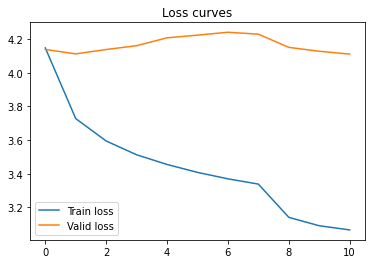

In [ ]:
import numpy as np
epochs = np.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

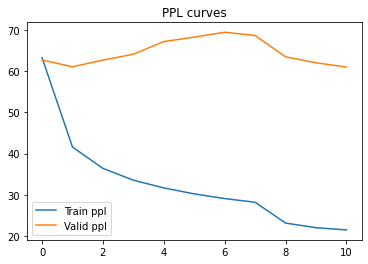

In [ ]:
epochs = np.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/np.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/np.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

In [ ]:
plot_cache

[(4.178999205238422, 3.9995838571794624),
 (3.7387595745068576, 3.970521905980979),
 (3.609801376065514, 3.9797455094388416),
 (3.531458226792578, 3.9864388757263853),
 (3.4733490156119005, 4.00522057843881),
 (3.428383651885224, 4.021451378552952),
 (3.3891653735406995, 4.036160557662829),
 (3.3570368124613896, 4.056110930334154),
 (3.159931156325688, 3.961843560769118),
 (3.110519249888533, 3.9525630871400934),
 (3.087279403406589, 3.9474780927998565),
 (3.070284212858198, 3.9465592269579353),
 (3.054818345790841, 3.9434651952125996),
 (3.0431292958330034, 3.944003568139026),
 (3.031691180311305, 3.9439499231310946),
 (3.021517295702578, 3.9438028785914927),
 (3.012109515167703, 3.944246198420588),
 (3.002993845702707, 3.945858317226949),
 (2.994180524366184, 3.945712163091619),
 (2.965663178262328, 3.9423195937966833),
 (2.962404592400025, 3.941408846642568),
 (2.961548609877266, 3.941104610091348),
 (2.9596470695025787, 3.9410258642052582),
 (2.9586169866389023, 3.9408075896912007)